In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys
from collections import defaultdict

from scipy.optimize import curve_fit

import glob
from matplotlib.backends import backend_pdf

import warnings
warnings.filterwarnings('ignore')

import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db",
                 table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df


# grabbing the latest db with the correct channel ID to PMT ID mapping
def load_hv(filename, voltages):

    """
    Makes a dictionary with key the channelId and as value the voltage set
    """
    geo = readSqlitedb()

    for line in open(filename, "r"):

        buff = line.split(",")

        if "{icarus" in buff[0]:

            try: 
                pmtid = int(buff[6])
                channel_id = geo[geo.pmt_id==pmtid].channel_id.values[0]
                value = int( buff[7] )
                          
                voltages[channel_id].append(value)
            
            except ValueError:
                continue 
    return

def load_files(runhvdb, path="/exp/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/equalization"):
    
    files = [ glob.glob(path+'_run%d_*.csv'%run)[0] for run in runhvdb.keys() ]
    df = pd.concat( [pd.read_csv(file, sep=',') for file in files ] )
    df=df.groupby("pmt").agg({'q':list, 'eq':list}).reset_index()
    
    return df

def get_list_for_ch( ch, df, voltages):
    
    bkg_q = np.array(df[df.pmt==ch].q.values[0])
    bkg_eq = np.array(df[df.pmt==ch].q.values[0])*0.02
    
    #filters for null or 0 values
    g = bkg_q[np.where( bkg_q > 0.05 )]
    eg = bkg_eq[np.where( bkg_q > 0.05 )]
    v = np.array(voltages[ch])[np.where( bkg_q > 0.05 )]
    
    return v, g, eg

def poly( v, a, k ):
    return a*np.power(v,k)

def poly_derivative ( v, a, k):
    return a*k*np.power(v, k-1)

def ipoly( g, a, ea, k, ek ): 
    
    v0 = np.power(g/a, 1./k)
    
    dvda = -(1./k)*np.power(0.5, 1./k)*np.power(1./a, 1./(k+1))
    dvdk = -(1./k**2)*np.power(0.5, 1./k)*np.power( (1./a)*(np.log(1./a)-np.log(0.5)), 1./k )
    
    ev0 = np.sqrt( (dvda*ea)**2 + (dvdk*ek)**2 )
    
    return v0, ev0

def dofit( data_x, data_y, error_y, g_target=0.4 ):
    """
    Args: 
        g_target: target gain in units of 10^7
    Returns: 
        ..
        ..
    """
    
    btrials=[5,6,7,7.5,8]
    trials=0
    b=btrials[0]
    
    params=[]
    pcov=[]
    
    repeatfit=True
    
    while repeatfit:
        try:
            #print("Try fit using b: %.2f" % b)
            params, pcov = curve_fit(poly, data_x, data_y, sigma=error_y, absolute_sigma=True, p0=[1e-13, b])
            repeatfit=False
        except:
            trials=trials+1
            if trials<len(btrials):
                b=btrials[trials]
                #print("Repeat fit using b: %.2f" % b)
            else: 
                #print("Finished the amount of trials available for fit")
                raise 
        else: 
            repeatfit=False
            
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(data_x)-10, np.max(data_x)+10, 1000 )
    yint = poly(xint, params[0], params[1])
    
    vnom, evnom= ipoly( g_target, params[0], stderr[0] , params[1], stderr[1] )
    
    #print(params, np.sqrt(np.diag(pcov)), vnom, evnom)
    
    return params, np.sqrt(np.diag(pcov)), xint, yint, vnom, evnom



def plotone( PMT, bb, vv ):
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))

    v, g, eg = get_list_for_ch(PMT, bb, vv)
    print( v, g)

    
    ax.set_ylabel("Gain [$10^7$ electrons]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(fontsize=16)
    
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    out=ax.errorbar( x=v, y=g, yerr=eg, label="Channel ID: %d" % PMT, **kargs )
    res = dofit( v, g, eg )

    p=res[0]
    ep=res[1]
    xint=res[2]
    yint=res[3]
    vnom=res[4]
    evnom=res[5] 

    label= "FIT $G = a \cdot V^k$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='V($4.0 \cdot 10^6$)= %d $\pm$ %d' % ( vnom, evnom )

    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    ax.axhline(y=0.4, color="red", linestyle="dotted")

    ax.set_ylabel("Gain [$10^7$ electrons]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()

    return fig, p[0], p[1]
    

def loaddata(runhvdb, date):

    bkg = load_files(runhvdb, path="/exp/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/equalization")

    voltages = defaultdict(list)
    for run, suffix in runhvdb.items(): 
        load_hv( "/exp/icarus/app/users/mvicenzi/pmt-calibration/gain/hv_files/voltagedb/Sy4527channels_{}_{}.sub".format(date,suffix), voltages )
    return voltages, bkg


No handles with labels found to put in legend.


[1646 1676 1694 1694 1696 1706 1726] [0.342274 0.382517 0.401854 0.417744 0.404528 0.415005 0.449545]


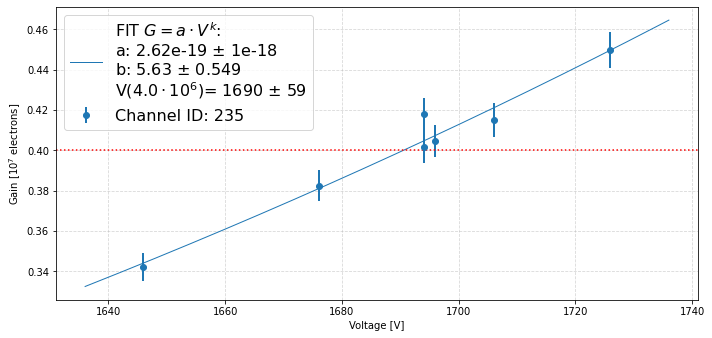

In [2]:
runhvdb = {  13646:"m30", 13642: "nominal", 13660:"nominal2", 13662:"nominal2", 13648:"p20", 13651:"p30", 13653:"p50" }
date = "20250915"
voltages, bkg = loaddata(runhvdb, date)

c = 235
fig, a, b, = plotone(c, bkg, voltages ) 

plt.grid(alpha=0.5,linestyle="dashed")
#plt.savefig("ch{}_calib_curv.png".format(c),dpi=100)
plt.show()

In [7]:
# SAVE MANY TO FILE
geo = readSqlitedb()

runhvdb = {  13646:"m30", 13642: "nominal", 13648:"p20", 13651:"p30", 13653:"p50" }
date = "20250915"
voltages, bkg = loaddata(runhvdb, date)

new_voltages = {}

pdf = backend_pdf.PdfPages("equalization_20250916.pdf")

for channel_id in range(0, 360):
    
    pmt_id = geo[geo.channel_id==channel_id].pmt_id.values[0]
    
    ## We skip switched-off channels
    ## 350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71 
    if channel_id in [ 215, 103, 71]:
        print("Channel_id: {} , pmt_id: {} is OFF".format(channel_id, pmt_id))    
        new_voltages[pmt_id] = 0
        continue
    
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    v, g, eg = get_list_for_ch(channel_id, bkg, voltages)
        
    # We skip some problematic channels
    # 248, 52, 21, 5 --> would go above 2000V     
    if channel_id in [ 248, 52, 21, 5 ]:
        print("Channel_id: {} , pmt_id: {} is skipped, no voltage change".format(channel_id, pmt_id))    
        new_voltages[pmt_id] = v[1] # old nominal
        plt.close()
        continue 
        
    try:
        out=ax.errorbar( x=v, y=g, yerr=eg, label=("Channel ID: %d" % channel_id), **kargs )
    
        try:
            target = 0.404
            res = dofit( v, g, eg, g_target=target )
            
            p=res[0]
            ep=res[1]
            xint=res[2]
            yint=res[3]
            vnom=res[4]
            evnom=res[5] 

            label= "FIT $a \cdot V^k$: \n"
            label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
            label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
            label+='V($4.0 \cdot 10^6$)= %d $\pm$ %d' % ( vnom, evnom )
            
            ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
            ax.axhline(y=target, color="red", linestyle="dotted")
            
            new_voltages[pmt_id] = int(vnom)
            
            if vnom > v[-1]:
                print("V {} is larger than {}. Interpolated value for channel_id: {} , pmt_id: {}".format(vnom, v[-1], channel_id, pmt_id))  
            if vnom < v[0]:
                print("V {} is smaller than {}. Interpolated value for channel_id: {} , pmt_id: {}".format(vnom, v[0], channel_id, pmt_id)) 
        
            if vnom > 2000: 
                print("Has V larger than 2000V channel_id: {} , pmt_id: {}. Set it to 0 instead".format(channel_id, pmt_id))      
                new_voltages[pmt_id] = 0
        
        except:
            print("Impossible to fit channel_id: {} , pmt_id: {}".format(channel_id, pmt_id))   
    except:
        print("Impossible to plot channel_id: {} , pmt_id: {}".format(channel_id, pmt_id)) 
    

    ax.set_ylabel("Gain [$10^7$ electrons]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    plt.grid(alpha=0.5,linestyle="dashed")
    pdf.savefig( fig )
    
    plt.close()


pdf.close()
print("ALL DONE")

Channel_id: 5 , pmt_id: 353 is skipped, no voltage change
Channel_id: 21 , pmt_id: 340 is skipped, no voltage change
Channel_id: 52 , pmt_id: 309 is skipped, no voltage change
Channel_id: 71 , pmt_id: 290 is OFF
Channel_id: 103 , pmt_id: 254 is OFF
Channel_id: 215 , pmt_id: 143 is OFF
Channel_id: 248 , pmt_id: 111 is skipped, no voltage change
ALL DONE


In [21]:
# create the HV file

def writeHVFile( oldfilename, newfilename, newvoltages, capvalues=False ):

    nfp = open(newfilename, "w")

    for line in open(oldfilename , "r"):

        buff = line.split(",")

        if '{icarus' in buff[0]:

            try:
                pmtID = int(buff[6])
            except ValueError:
                print("Warning: invalid PMT id for {}".format(buff[6]))
                line = ",".join(buff)
                nfp.write(line)
                continue

            oldvalue = int(buff[7])
            value=oldvalue
            
            #If a new value exists override it
            try:
                value = newvoltages[pmtID]
            except:
                print( "WARNING: No voltage changes for PMT {}".format(pmtID) )
                #continue
                
            if abs(value-oldvalue) < 1:
                print("No change for {}".format(pmtID))   

            hwarning = 20
            hcaring = 5

            # Cap values over 2000 V
            if value > 2000:
                print( "WARNING: Capped voltage to 2000V for PMT {}".format(pmtID) )
                value=2000
            #else:
                #print( "Replacing {}V with {}V for PMT {}".format(oldvalue, value, pmtID) )

            # here we write the new line to file
            newline = buff
    
            newline[7] = " " + str( value ) #Main nominal value
            newline[9] = " " + str( value+hwarning )
            newline[10] = " " + str( value+hcaring )
            newline[11] = " " + str( value-hcaring )
            newline[12] = " " + str( value-hwarning )+" }\n"

            line =  ",".join(newline)
            nfp.write(line)

        else:
            line = ",".join(buff)
            nfp.write(line)

    print( "Create new file {}".format(newfilename) )
    nfp.close()

    return


#vv = [new_voltages[key] for key in new_voltages.keys()]
#print( np.mean(vv), np.std(vv), np.min(vv), np.max(vv) )
#plt.hist( vv, bins=20, range=(1300, 2200) )  
#plt.show()

#Put in manually some channel 
#new_voltages[93] = 1688
#new_voltages[95] = 1721
#new_voltages[104] = 1577
#new_voltages[113] = 1630
#new_voltages[148] = 1713
#new_voltages[194] = 1672
#new_voltages[236] = 1666
#new_voltages[263] = 1833
#new_voltages[337] = 1733

#impossible fits, but needed for digital signals
#new_voltages[262]=1946
#new_voltages[248]=1681

writeHVFile("../hv_files/voltagedb/Sy4527channels_20250915_nominal.sub", "../hv_files/voltagedb/Sy4527channels_20250916_calibrated.sub", new_voltages, True)

No change for 111
No change for 143
No change for 254
No change for 309
No change for 340
No change for 353
Create new file ../hv_files/voltagedb/Sy4527channels_20250916_calibrated.sub


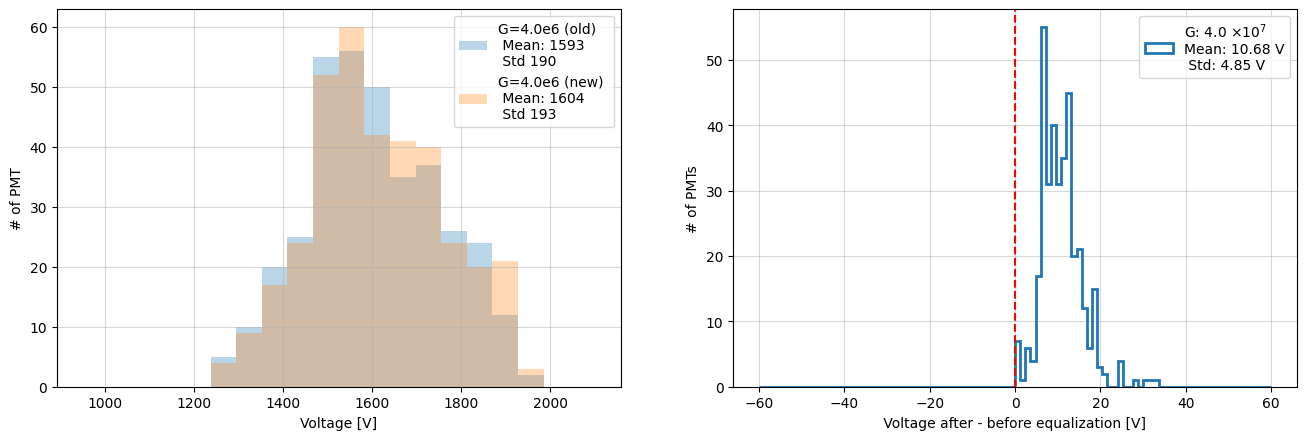

In [22]:
old_hv_dict = defaultdict(list)
new_hv_dict = defaultdict(list)
load_hv( "../hv_files/voltagedb/Sy4527channels_20250915_nominal.sub", old_hv_dict )
load_hv( "../hv_files/voltagedb/Sy4527channels_20250916_calibrated.sub", new_hv_dict )

old_hv=np.array([ ii[1][0] for ii in old_hv_dict.items() ])
new_hv=np.array([ ii[1][0] for ii in new_hv_dict.items() ])

fig, ax = plt.subplots(1,2, figsize=(16, 5),dpi=100)

ax[0].hist( old_hv, bins=20, range=(950, 2100), alpha=0.3, label="G=4.0e6 (old) \n Mean: %d \n Std %d" %  ( np.mean(old_hv), np.std(old_hv) ) )
ax[0].hist( new_hv, bins=20, range=(950, 2100), alpha=0.3, label="G=4.0e6 (new) \n Mean: %d \n Std %d" %  ( np.mean(new_hv), np.std(new_hv) ) )

ax[0].set_ylabel("# of PMT")
ax[0].set_xlabel("Voltage [V]")
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].hist( new_hv-old_hv, bins=100, range=(-60, 60),
           label=r"G: 4.0 $\times 10^7$"+"\nMean: {:.2f} V\n Std: {:.2f} V".format(np.mean(new_hv-old_hv),np.std(new_hv-old_hv)),
           histtype='step', lw=2.0 )
ax[1].set_ylabel("# of PMTs")
ax[1].set_xlabel(" Voltage after - before equalization [V] " )
ax[1].axvline(x=0, color="red", linestyle="dashed")
ax[1].grid(alpha=0.5)
ax[1].legend()

#plt.legend()
plt.savefig("voltage_distribution.png")

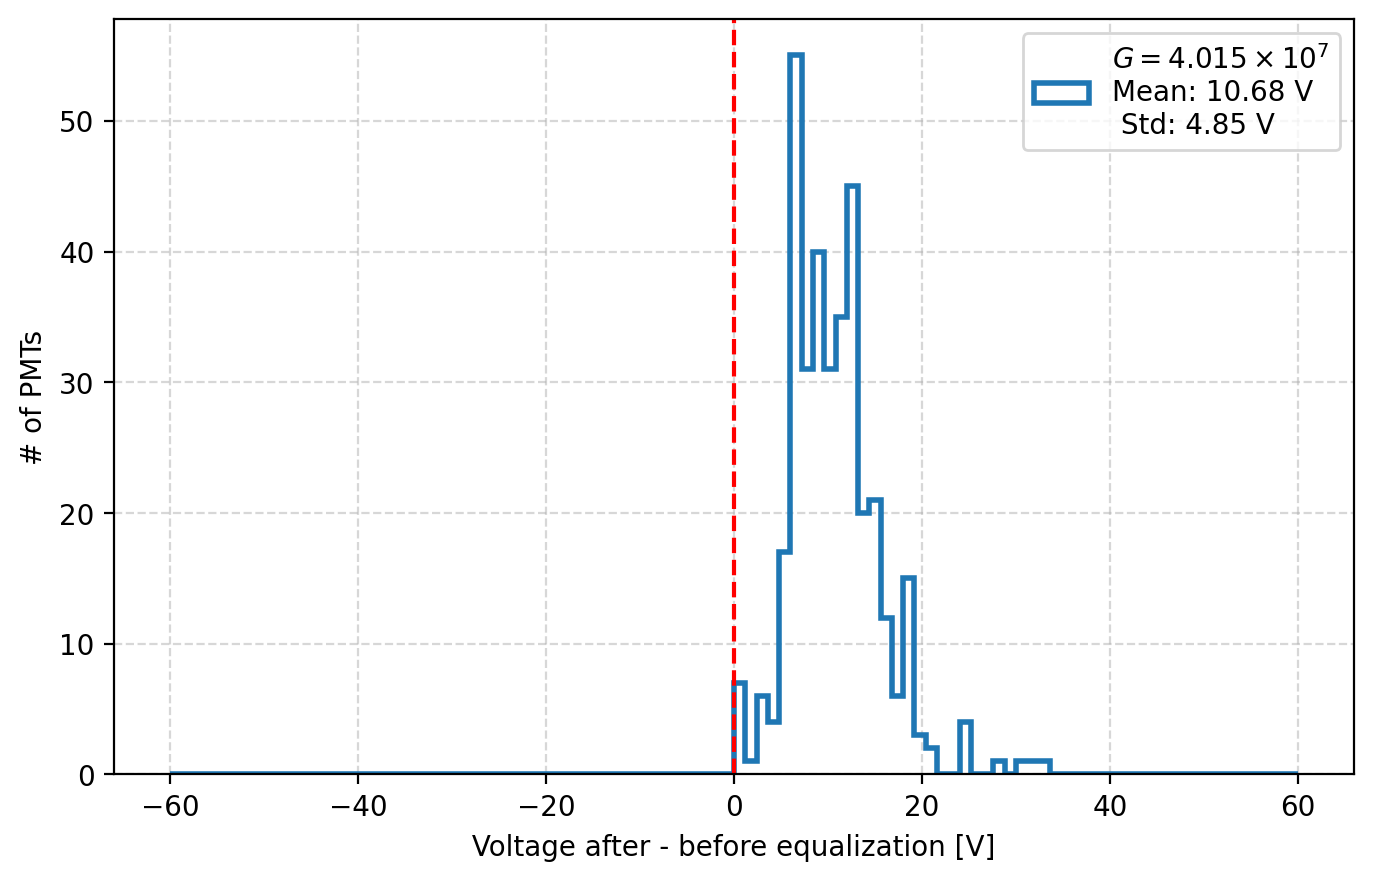

In [23]:
fig = plt.figure(figsize=(8,5), dpi=200)
diff = new_hv-old_hv
plt.hist( diff, bins=100, range=(-60, 60), label=r"$G=4.015 \times 10^7$"+"\nMean: {:.2f} V\n Std: {:.2f} V".format(np.mean(diff),np.std(diff)), histtype='step', lw=2.0 )
plt.ylabel("# of PMTs")
plt.xlabel(" Voltage after - before equalization [V] " )
plt.axvline(x=0,color="red",linestyle="dashed")
plt.legend()
plt.grid(alpha=0.5,linestyle="dashed")
#plt.xlim((-60,20.))
plt.savefig("voltage_histogram.png")

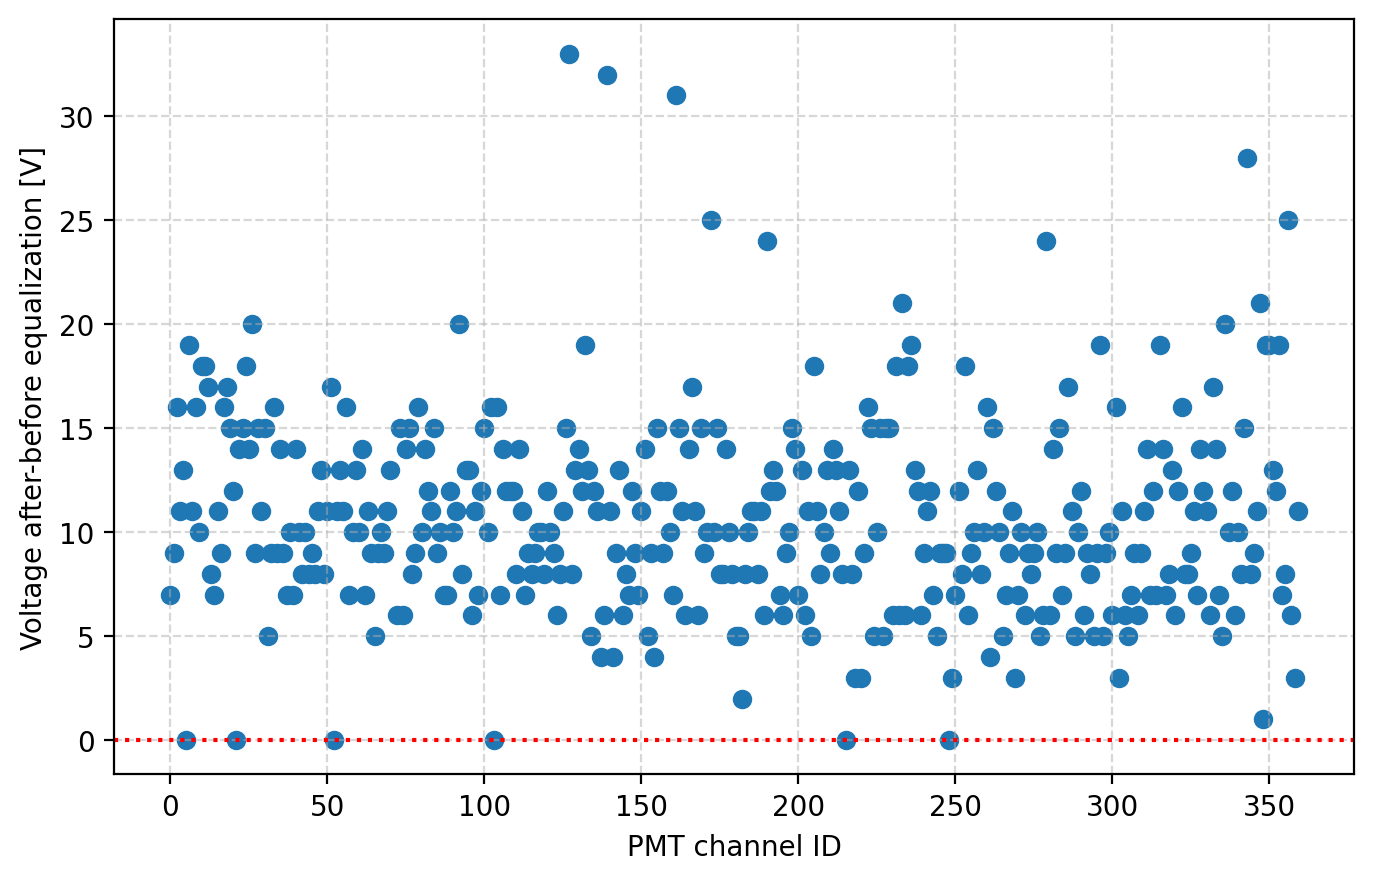

In [24]:
fig = plt.figure(figsize=(8,5),dpi=200)
plt.scatter(old_hv_dict.keys(),new_hv-old_hv, marker="o")
plt.axhline(y=0.0, color="red", linestyle='dotted')

#skippedPMTs = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290,
#               51, 79]
#plt.scatter(skippedPMTs,np.zeros(len(skippedPMTs)), marker="o", color="green")

#driftPMTs = [ 298 ] #channels
driftPMTs = [ ]
change=[]
old_hv_drift=[]
new_hv_drift=[]
for id in driftPMTs:
    change.append(new_hv_dict[id][0]-old_hv_dict[id][0])
    old_hv_drift.append(old_hv_dict[id][0])
    new_hv_drift.append(new_hv_dict[id][0])
    
#plt.scatter(driftPMTs,change, marker="x", color="red", label="WEST HV issues\n- now fixed")

#nochangePMTs = [ 279 ]
nochangePMTs = [  ]
nochange=[]
for id in nochangePMTs:
    nochange.append(new_hv_dict[id][0]-old_hv_dict[id][0])
#plt.scatter(nochangePMTs,nochange, marker="o", color="green", label="No/bad G-V curve")

#for id in range(80,100):
#    print(id)
#    print(new_hv_dict[id][0]-old_hv_dict[id][0])

#plt.ylim(-10,10)

plt.xlabel("PMT channel ID")
plt.ylabel("Voltage after-before equalization [V]")
#plt.legend()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("delta_voltage.png")

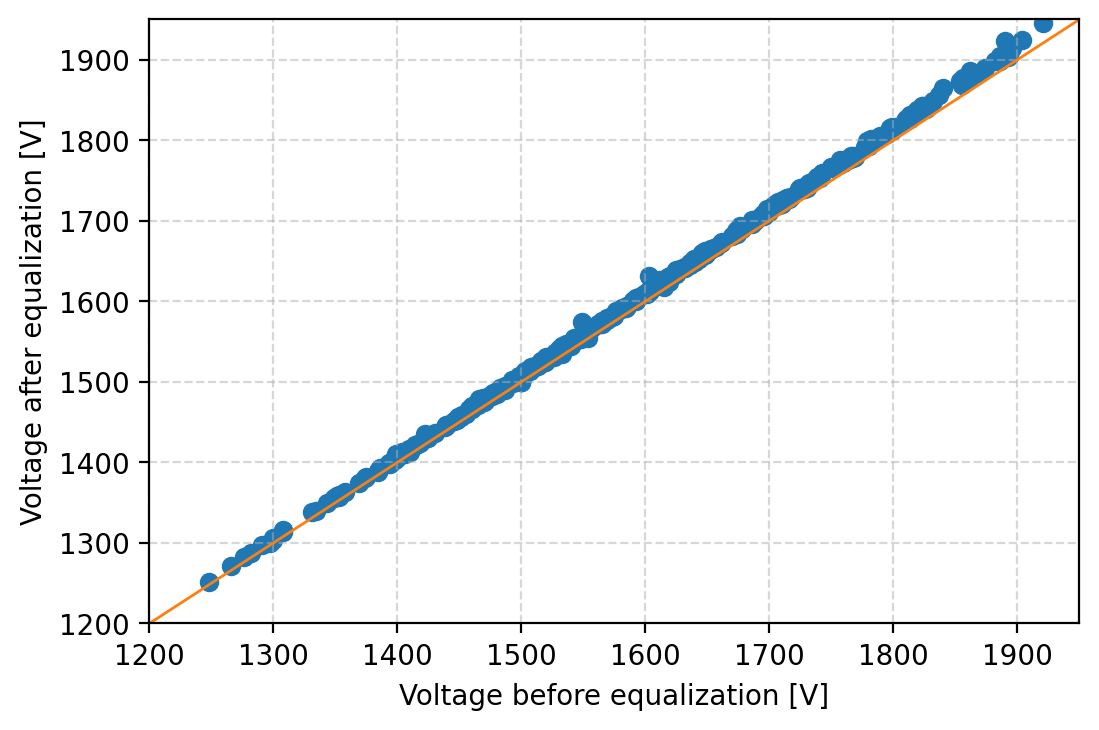

In [25]:
plt.figure(dpi=200)

x = np.arange(0,2000,1)
plt.plot(x,x,lw=1, color="C1")

plt.scatter(old_hv,new_hv, marker="o")
#plt.scatter(old_hv_drift,new_hv_drift, marker="x", color="red", label="WEST HV issues\n- now fixed")

plt.xlim((1200,1950))
plt.ylim((1200,1950))
plt.xlabel("Voltage before equalization [V]")
plt.ylabel("Voltage after equalization [V]")
#plt.legend()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("preafter2D_voltage.png")
plt.show()

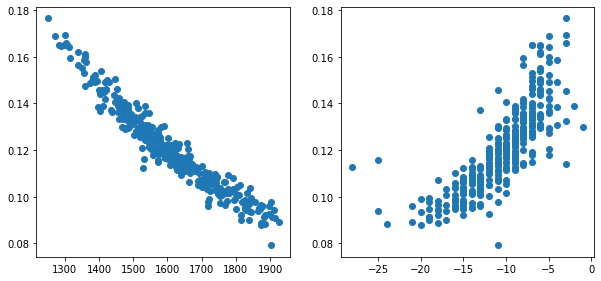

In [26]:
runhvdb = {  13646:"m30", 13642: "nominal", 13648:"p20", 13651:"p30", 13653:"p50" }
date = "20250915"
voltages, bkg = loaddata(runhvdb, date)

valid_pmts = [ pmt for pmt in range(0, 360) if pmt not in [ 350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71, 51, 79 ] ]  
gains_array = [  get_list_for_ch(pmt, bkg, voltages)[1] for pmt in valid_pmts ]
gains_diff = [ np.max(val)-np.min(val) for val in gains_array ]
new_volt_array = [  new_hv_dict.get(pmt)[0] for pmt in range(0, 360) if pmt in valid_pmts ]
delta_volt_array = [  old_hv_dict.get(pmt)[0]-new_hv_dict.get(pmt)[0] for pmt in valid_pmts ]

fig, ax = plt.subplots(1,2, figsize=(10, 4.6))

ax[0].scatter( new_volt_array, gains_diff )
ax[1].scatter( delta_volt_array, gains_diff )